In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
import glob
import os

plt.style.use('ggplot') # Make the graphs a bit prettier

In [2]:
data = {}

for path in glob.glob(os.path.expanduser("~/dev/ma/data/results/2017-02-24/*.json")):
  for typename, items in json.load(open(path)).items():
    if typename in data:
      data[typename].update(items)
    else:
      data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [6]:
frames['program_run'].loc[lambda x: x.binary == './louvain'][frames['algorithm_run'].groupby('program_run_id').size() < 58]['graph']


028c0c46-88a9-4767-9d24-bb2766927369     ../data/lfr-100000-mu-0.2.metis.graph
2268a88b-aef8-4c10-b1dd-5056cd472063     ../data/lfr-100000-mu-0.2.metis.graph
35a90978-cbe8-4e33-9a81-dd5fee2a1a60     ../data/lfr-100000-mu-0.2.metis.graph
4a8c3e93-c0c3-459f-a14b-66a1e2dd9795    ../data/lfr-1000000-mu-0.2.metis.graph
70fc8bf2-df9f-4e04-a2be-c2b56ebcd710    ../data/lfr-1000000-mu-0.2.metis.graph
76ac14a6-6a1c-4e30-8145-c44512388742    ../data/lfr-1000000-mu-0.2.metis.graph
aab85dde-61f3-43cd-8ae2-48d10c2e4d9e     ../data/lfr-100000-mu-0.2.metis.graph
ad6db6fe-cc6b-4440-84a5-b77481b51a32    ../data/lfr-1000000-mu-0.2.metis.graph
b779171a-a00d-4a0b-8bc3-2d6c381b61e1     ../data/lfr-100000-mu-0.2.metis.graph
db208f5e-cc03-4fa7-ba54-5ddbc2d3c235    ../data/lfr-1000000-mu-0.2.metis.graph
Name: graph, dtype: object

In [7]:
frames['program_run'].graph.unique()

array(['../data/lfr-100000-mu-0.2.metis.graph',
       '../data/in-2004.metis.graph', '../data/com-dblp.ungraph.txt.graph',
       '../data/com-lj.ungraph.txt.graph', '../data/uk-2002.metis.graph',
       '../data/com-amazon.ungraph.txt.graph',
       '../data/lfr-1000000-mu-0.2.metis.graph'], dtype=object)

In [9]:
graphs = frames['program_run'].loc[lambda x: x.graph.str.contains("uk-")].loc[lambda x: x.binary == './louvain']
algos = frames['algorithm_run'].merge(graphs, left_on='program_run_id', right_index=True)

In [10]:
graphs[:1]

,graph,time,timestamp,output,binary,commit,edge_count,node_count,seed,ground_proof
528ee835-1581-499c-9397-bb8c43dfa8f5,../data/uk-2002.metis.graph,NaN,2017-02-23 12:22:42 +0100,NaN,./louvain,3a926ce17b2d2022d1eb0261933c35ab7047ab89,261787258.0,18520486.0,350034241.0,NaN


In [11]:
frames['algorithm_level'] \
    .loc[lambda x: x.level == 0] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(graphs, left_on='program_run_id', right_index=True) \
    .loc[lambda x: x.algorithm.str.contains("sequential")] \
    ['cluster_count'] \
    .mean()

771295.3

In [23]:
partitions = frames['partition']
partitions['algorithm'] = frames['partition'] \
    .merge(frames['program_run'], how='left', left_on='program_run_id', right_index=True) \
    .apply(lambda x: x.binary if x.algorithm == 'external' else x.algorithm, axis=1)

In [24]:
frames['algorithm_level'] \
    .loc[lambda x: x.level == 0] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(graphs, left_on='program_run_id', right_index=True) \
    .merge(partitions, left_on='partition_id', right_index=True) \
    .loc[lambda x: x.algorithm_x.str.contains("partitioned")] \
    .groupby(['algorithm_y', 'size', 'allow_move_to_ghosts'])['cluster_count'].mean()

algorithm_y                                            size  allow_move_to_ghosts
chunk                                                  4     False                     903232
                                                             True                      959862
                                                       32    False                     943180
                                                             True                     1028918
                                                       128   False                     957007
                                                             True                     1045697
                                                       1024  False                    1033051
                                                             True                     1102469
cluster_based                                          4     False                     773232
                                                             True       

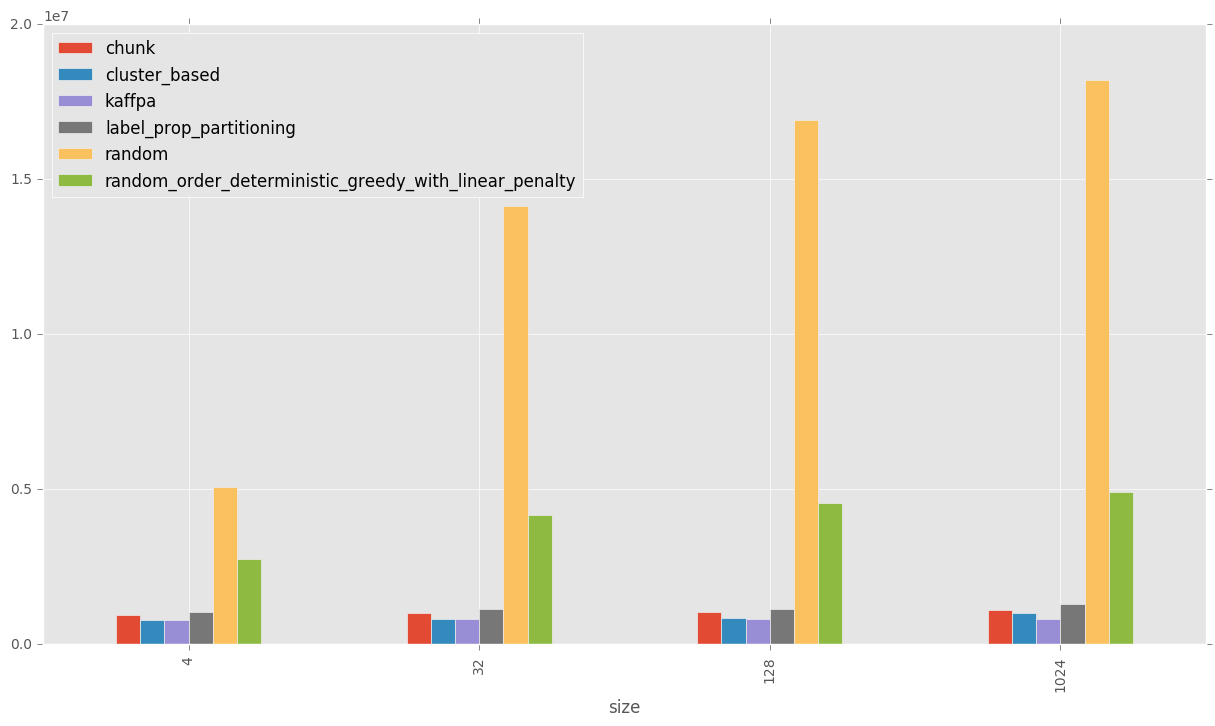

In [29]:
groups = frames['algorithm_level'] \
    .loc[lambda x: x.level == 0] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(graphs, left_on='program_run_id', right_index=True) \
    .merge(partitions, left_on='partition_id', right_index=True) \
    .loc[lambda x: x.algorithm_x.str.contains("partitioned")] \
    .loc[lambda x: x.allow_move_to_ghosts] \
    .loc[lambda x: ~x.algorithm_y.isin(["deterministic_greedy_with_linear_penalty"])] \
    .groupby(['algorithm_y'], as_index=False)


pd.DataFrame({algo: levels.groupby('size')['cluster_count'].mean() for algo, levels in groups}).plot.bar(figsize=(15,8))

In [25]:
frames['partition_element'] \
    .merge(partitions, left_on='partition_id', right_index=True) \
    .merge(algos, left_on='partition_id', right_on='partition_id') \
    .groupby(['size', 'algorithm_x'])['cut_weight'].mean()

size  algorithm_x                                          
4     chunk                                                      9404346
      cluster_based                                              1434465
      deterministic_greedy_with_linear_penalty                  53357687
      kaffpa                                                      837043
      label_prop_partitioning                                   10675758
      random                                                   196338953
      random_order_deterministic_greedy_with_linear_penalty     60809430
32    chunk                                                     12299093
      cluster_based                                              2741584
      deterministic_greedy_with_linear_penalty                  71550827
      kaffpa                                                     1594437
      label_prop_partitioning                                   13906613
      random                                                   2

In [26]:
frames['partition_element'] \
    .merge(partitions, left_on='partition_id', right_index=True) \
    .merge(algos, left_on='partition_id', right_on='partition_id') \
    .groupby(['size', 'algorithm_x'])['ghost_count'].mean()

size  algorithm_x                                          
4     chunk                                                    1.073760e+06
      cluster_based                                            2.424708e+05
      deterministic_greedy_with_linear_penalty                 2.883604e+06
      kaffpa                                                   1.521628e+05
      label_prop_partitioning                                  9.389110e+05
      random                                                   1.097264e+07
      random_order_deterministic_greedy_with_linear_penalty    3.673715e+06
32    chunk                                                    2.263837e+05
      cluster_based                                            6.858232e+04
      deterministic_greedy_with_linear_penalty                 7.690247e+05
      kaffpa                                                   4.597378e+04
      label_prop_partitioning                                  1.886402e+05
      random                

In [27]:
frames['partition_element'] \
    .groupby('partition_id', as_index=False)['ghost_count'].sum() \
    .merge(partitions, left_on='partition_id', right_index=True) \
    .merge(algos, left_on='partition_id', right_on='partition_id') \
    .groupby(['size', 'algorithm_x'])['ghost_count'].mean()

size  algorithm_x                                          
4     chunk                                                      4295038
      cluster_based                                               969883
      deterministic_greedy_with_linear_penalty                  11534417
      kaffpa                                                      608651
      label_prop_partitioning                                    3755644
      random                                                    43890568
      random_order_deterministic_greedy_with_linear_penalty     14694859
32    chunk                                                      7244277
      cluster_based                                              2194634
      deterministic_greedy_with_linear_penalty                  24608789
      kaffpa                                                     1471161
      label_prop_partitioning                                    6036488
      random                                                   2

(array([ 883.,    3.,    1.,    0.,    2.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([  1.00000000e+00,   2.08800000e+01,   4.07600000e+01,
          6.06400000e+01,   8.05200000e+01,   1.00400000e+02,
          1.20280000e+02,   1.40160000e+02,   1.60040000e+02,
          1.79920000e+02

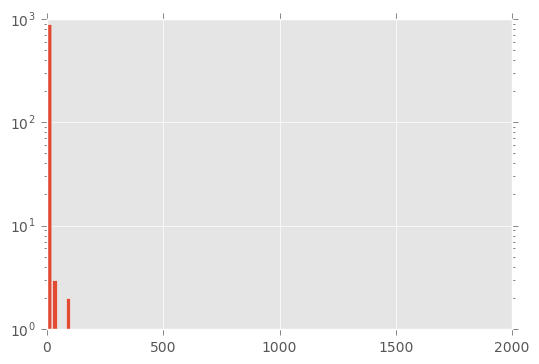

In [42]:
connected_component_sizes = frames['partition_element'] \
    .merge(frames['partition'], left_on='partition_id', right_index=True) \
    .merge(algos, left_on='partition_id', right_on='partition_id') \
    [['size', 'algorithm_x', 'connected_components']].iloc[0]['connected_components']
    
plt.hist(pd.Series(connected_component_sizes), log=True, bins=100) 